In [119]:
import re
import random
import pandas as pd
import hashlib

In [120]:
with open('certcards2.txt', mode='r', encoding='utf8') as f:
    all_cards = f.read()
    
card_split_pattern = r'\n\n\n\d+\n'
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r'(.+?)\n([\s\S]+)', re.DOTALL)
cards = [(match.group(1), match.group(2)) for cstring in all_cards if (match := re.search(card_pattern, cstring))]

# removing the cards that have no content and trimming
cards = [(subject, stripped_content) for subject, content in cards if len(stripped_content := content.strip()) > 5]

def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode('utf-8')).hexdigest()


def remake_card_document(existing_cards: pd.DataFrame, filename: str='certcards2.txt'):
    with open(filename, mode='w', encoding='utf8') as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write('\n'*6)
            f.write(str(i)+'\n')  
            f.write(row['head']+'\n')
            f.write(row['body'])
            i+=1
    print(F"Cards found: {existing_cards.shape[0]}")
    print(F"Total card age: {abs(existing_cards['age'].sum()):.2f}")


existing_cards = pd.DataFrame(cards, columns=['head', 'body'])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards['hash'] = existing_cards['body'].apply(hash_string_md5)
existing_cards

card_ages = pd.read_json('card_ages.json')
card_ages = card_ages.drop_duplicates(subset=['hash'], keep='first')

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[['hash', 'age']],
    left_on='hash', right_on='hash',
    how='left'
)

cards_to_age['head'] = cards_to_age['head'].str.strip()

if cards_to_age['age'].mean() > 80: age_factor = .5
else: age_factor = 1

cards_to_age['age'] = cards_to_age['age'].fillna(0)
# cards_to_age['age'] = cards_to_age['age'] * age_factor
cards_to_age['age'] = cards_to_age['age'] + [random.expovariate(.60) for _ in cards_to_age.index]
# cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1/age_factor) for _ in cards_to_age.index]

# Adding priority age growth to cards for upcoming certifications
priority_headers = ['Azure Developer Associate']
priority_cards_mask = cards_to_age['head'].isin(priority_headers)
cards_to_age.loc[priority_cards_mask, 'age'] = cards_to_age.loc[priority_cards_mask, 'age'] * 1.05

cards_to_age = cards_to_age.drop_duplicates(subset=['hash'], keep='first')

cards_to_age['subject_mean_age'] = cards_to_age.groupby('head')['age'].transform('mean')
cards_to_age['subject_highest_age'] = cards_to_age.groupby('head')['age'].transform('max')
cards_to_age['subject_age_sum'] = cards_to_age.groupby('head')['age'].transform('sum')
cards_to_age['head_random_roll'] = cards_to_age.groupby('head')['head'].transform(lambda x: random.random())


cards_to_age.sort_values('hash')[['age', 'head', 'hash']].to_json('card_ages.json', indent=2)

existing_cards = cards_to_age

In [121]:
stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean', 'max'], 'head': 'count'}).sort_values(('age', 'sum'))
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,age_max,head_count
SharePoint,144.527734,36.131933,45.980361,4
RAG Project,407.647613,25.477976,40.772041,16
IW Migration,619.296154,77.412019,236.695106,8
Azure AD Authentication,626.503807,48.192601,107.817107,13
Asynchronous Python,853.417987,18.552565,31.591175,46
Azure DevOps Pipelines,864.552769,33.252030,97.961286,26
Azure Functions + Visual Studio,888.511191,68.347015,272.224046,13
Email Auth and Security,916.145673,76.345473,191.642622,12
Open Source/GitHub,981.813975,61.363373,172.910836,16
Todd Ideas,1039.815333,103.981533,269.070573,10


# Histogram

sum of ages: ~41842.98


<Axes: >

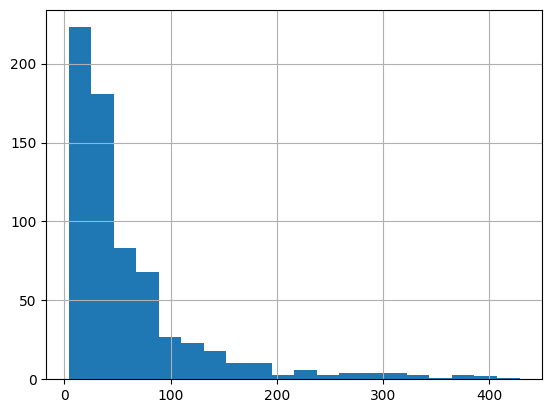

In [122]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

# Completely Random Shuffle

In [123]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [124]:
# existing_cards = existing_cards.sort_values('age', ascending=False)
# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)
# existing_cards.head(10)

# Headers with fewest notes first

In [125]:
# frequency = existing_cards['head'].value_counts(ascending=True)

# existing_cards = pd.merge(
#     left=existing_cards,
#     right=frequency.rename('frequency'),
#     left_on='head', right_index=True,
#     how='left'
# )
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] * -1
# existing_cards['age'] = existing_cards['age'] * -1


# existing_cards.sort_values(['frequency', 'subject_highest_age', 'age'], ascending=True, inplace=True)

# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)

# existing_cards.head(10)

# Focus on one header

In [126]:
# heads = existing_cards['head'].value_counts()
# heads = heads[heads > 5].index.tolist()
# one_header = random.sample(heads, 1)[0]
# existing_cards['pick_head'] = existing_cards['head'].apply(
#     lambda h: 0 if h == one_header else 1 
# )

# remake_card_document(existing_cards=existing_cards.sort_values('pick_head'))

## Header with oldest cards first

In [127]:
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards.sort_values(['oldest', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

## Headers with greatest mean card age first

In [128]:
# existing_cards.sort_values(['subject_mean_age', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

## Headers with greatest age sum first

In [129]:
# existing_cards.sort_values(['subject_age_sum', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# N-fold shuffle


## Age Sum

In [130]:
# n=3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Age Mean

In [131]:
# n=3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)



## Age Max

In [132]:
# n = 1
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# if existing_cards['age'].sum() > 0:
#     existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['age'] = existing_cards['age'] *-1
# # existing_cards.sort_values(['n_fold', 'subject_highest_age', 'age'], inplace=True)
# existing_cards.sort_values(['age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Card Count

In [133]:
n=10
existing_cards['frequency']  = existing_cards.groupby('head').transform('count')['body']
existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
existing_cards['n_fold'] = existing_cards['count'] // n

if existing_cards['age'].sum() > 0:
    # existing_cards['neg_subject_highest_age'] = existing_cards['subject_highest_age'] *-1
    existing_cards['neg_age'] = existing_cards['age'] *-1
existing_cards.sort_values(['n_fold', 'frequency', 'neg_age'], inplace=True)
remake_card_document(existing_cards=existing_cards)

existing_cards.head(10)



Cards found: 677
Total card age: 41842.98


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,frequency,count,n_fold,neg_age
198,SharePoint,The Content-Type header specifies the media ty...,be73d4960e24600a4ca6aaa317b949d4,45.980361,36.131933,45.980361,144.527734,0.424179,4,0,0,-45.980361
648,SharePoint,Uploading large files (typically over 4MB) req...,bfd8e2f230f1a2fa1fdfae9d0abf5827,39.912646,36.131933,45.980361,144.527734,0.424179,4,1,0,-39.912646
428,SharePoint,Application Permissions (App-Only)\nDefinition...,481b9e6445e9c0b8959a6e31cf78bce2,39.708583,36.131933,45.980361,144.527734,0.424179,4,2,0,-39.708583
199,SharePoint,"To access SharePoint resources using REST, con...",a05440d48a54d44298e2df840d9f1192,18.926144,36.131933,45.980361,144.527734,0.424179,4,3,0,-18.926144
29,IW Migration,SSMS Query Editor\nA text-based interface in S...,d2f66ab99683b7f7f9daf28c65ee33a0,236.695106,77.412019,236.695106,619.296154,0.550090,8,0,0,-236.695106
265,IW Migration,Transaction Handling (SQL Server)\nA mechanism...,e235e7caaccefbe2132e6d59bc9d0dbe,96.758708,77.412019,236.695106,619.296154,0.550090,8,1,0,-96.758708
489,IW Migration,Refactoring and Normalization (Access/SQL Serv...,08890f3b4934c1888406c827168eab08,82.663997,77.412019,236.695106,619.296154,0.550090,8,2,0,-82.663997
30,IW Migration,Locking and Concurrency Control (SQL Server)\n...,bff97dc4943dd88730fe8f10f0d190ab,57.291523,77.412019,236.695106,619.296154,0.550090,8,3,0,-57.291523
266,IW Migration,Database Backup and Restore (SSMS)\nBuilt-in w...,083bd09675725caa49480be3eede358f,49.462117,77.412019,236.695106,619.296154,0.550090,8,4,0,-49.462117
490,IW Migration,Indexing (Access/SQL Server)\nA strategy for i...,5fdf5297e446f6ea2d26a3cc3c1cffd8,45.675128,77.412019,236.695106,619.296154,0.550090,8,5,0,-45.675128



## Random

In [134]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n
# existing_cards['age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)

In [135]:
existing_cards.sort_values('age').head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,frequency,count,n_fold,neg_age
647,Vocab,"Well of Lost Plots, Fforde\nTabula rasa\nnoun ...",12272c6b1494f8d10a923f0a2fbedebd,4.166565,44.260400,297.826264,3452.311187,0.889046,78,77,7,-4.166565
427,Vocab,"Well of Lost Plots, Fforde\nFrontispiece\nnoun...",7310a0bde97b2c037971f66e94d4be44,6.062514,44.260400,297.826264,3452.311187,0.889046,78,76,7,-6.062514
214,RAG Project,Quart\nA Python web framework like Flask but w...,11660c33096c6150cc478cb8bd9a72a3,7.093115,25.477976,40.772041,407.647613,0.016935,16,15,1,-7.093115
646,Vocab,"Well of Lost Plots, Fforde\nThe Decameron\nnou...",d9044a52b873016ee0bc48f05a511463,7.095204,44.260400,297.826264,3452.311187,0.889046,78,75,7,-7.095204
426,Vocab,"Well of Lost Plots, Fforde\nSplit infinitive\n...",82886736ab28c503fd90729dc76b0a2f,7.419526,44.260400,297.826264,3452.311187,0.889046,78,74,7,-7.419526
617,PnP PowerShell,Invoke-WebRequest Parameters (Microsoft.PowerS...,8464b01faa4c39ac8c219501be8b0d8b,8.004675,49.088662,401.695772,3534.383655,0.236948,72,71,7,-8.004675
425,Vocab,"Well of Lost Plots, Fforde\nLych-gate\nnoun | ...",a79c049cddc049b36a63f7ddab18741f,8.117554,44.260400,297.826264,3452.311187,0.889046,78,73,7,-8.117554
194,Vocab,"Well of Lost Plots, Fforde\nHomburg hat\nnoun ...",f118690dfa21e440d0a1df501ab1f622,8.231540,44.260400,297.826264,3452.311187,0.889046,78,72,7,-8.231540
645,Vocab,"Well of Lost Plots, Fforde\nPinafore\nnoun | P...",ca575c0f756990a24e858ffc514308ef,8.355168,44.260400,297.826264,3452.311187,0.889046,78,71,7,-8.355168
644,Vocab,"Well of Lost Plots, Fforde\nInvigilating\nverb...",bd295e8b0e46b7bb38fadbd1d510ac22,8.540551,44.260400,297.826264,3452.311187,0.889046,78,70,7,-8.540551


In [136]:
existing_cards.head(10).sum()

head                   SharePointSharePointSharePointSharePointIW Mig...
body                   The Content-Type header specifies the media ty...
hash                   be73d4960e24600a4ca6aaa317b949d4bfd8e2f230f1a2...
age                                                           713.074312
subject_mean_age                                              608.999849
subject_highest_age                                          1604.092078
subject_age_sum                                              4293.887858
head_random_roll                                                4.997257
frequency                                                             64
count                                                                 21
n_fold                                                                 0
neg_age                                                      -713.074312
dtype: object

In [137]:
existing_cards['age'].mean()

61.80647709758695